# Hook Displayer Helper Notebook

This notebook contains helper code that allows one to render a pre-processed 8-bar hook using LilyPond based on the song name.

## Setup

In [22]:
# First mount your Google drive
from google.colab import drive
drive.mount('/content/gdrive')

# We'll use the note/chord encodings from simple feedforward as a starting point
ff_path = 'gdrive/My Drive/Colab Notebooks/Thesis/simple-feedforward' # change this if needed

# Imports
import os
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import softmax

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load data

### Import from simple-feedforward

In [23]:
# Load encoded notes and chords
encoded_notes_path = os.path.join(ff_path, "encoded_notes.npy")
encoded_chords_path = os.path.join(ff_path, "encoded_chords.npy")
encoded_notes = np.load(encoded_notes_path)
encoded_chords = np.load(encoded_chords_path)

# Load song names
song_names_path = os.path.join(ff_path, "song_names.pkl")
opened_file = open(song_names_path, "rb")
song_names = pkl.load(opened_file)
opened_file.close()

num_hooks = len(song_names)
print(f"Loaded data. Number of 8-bar hooks: {num_hooks}")

Loaded data. Number of 8-bar hooks: 3448


### Set up Music21 dev environment

In [24]:
import music21
from IPython.display import Image, Audio

print("updating apt-get...")
!apt-get update

# enables music21 to render images of musical notes
print("\ninstalling lilypond...")
!apt-get install lilypond > /dev/null

# converts midi files to wav files into order to play them
print("installing fluidsynth...")
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

!fluidsynth --version
!lilypond --version

updating apt-get...
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-driver

These functions will make it easy to show and play back Music21 streams

In [25]:
# Display the music score
def show(music):
    display(Image(str(music.write('lily.png'))))

# Play the music at a user-specified bpm, or 120 if no bpm specified
def play(music, bpm=120):
    s = music21.stream.Stream()
    s.append(music21.tempo.MetronomeMark(number=bpm))
    s.append(music)
    filename = s.write('mid')
    !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
    display(Audio(filename + '.wav'))

### Translate encoded notes into a Music21 stream

In [26]:
C3_MIDI_VAL = 48
NOTE_ONE_HOT_VECTOR_LENGTH = 38
CHORD_ONE_HOT_VECTOR_LENGTH = 32
NUM_BEATS_IN_4_BARS = 16
NUM_BEATS_IN_8_BARS = 32
NUM_16_NOTES_IN_4_BARS = 64
NUM_16_NOTES_IN_8_BARS = 128
FLATTENED_NOTES_VECTOR_SIZE = NOTE_ONE_HOT_VECTOR_LENGTH * NUM_16_NOTES_IN_8_BARS

# Given a flattened notes encoding vector, return the one-hot vector at a particular
# timestep (0-indexed, so basically the column number of the 2D representation)
def get_note_one_hot(encoding, timestep):
    start_idx = timestep * NOTE_ONE_HOT_VECTOR_LENGTH
    end_idx = start_idx + NOTE_ONE_HOT_VECTOR_LENGTH
    return encoding[start_idx:end_idx]

# Given a one-hot encoding of a note, return the MIDI value of that note, or 0
# if the note encodes a hold
def decode_note_one_hot(one_hot):
    idx = np.argmax(one_hot)
    if idx == 0:
        return 0
    else:
        return idx + C3_MIDI_VAL - 1

# Given an encoding of a melody, return a Music21 stream representing that melody
def translate_notes(encoding):
    # Initialize music21 stream
    s = music21.stream.Part()

    # First, move timestep i to the first note in the melody
    i = 0
    while i < NUM_16_NOTES_IN_8_BARS:
        one_hot = get_note_one_hot(encoding, i)
        note_val = decode_note_one_hot(one_hot)
        if note_val != 0:
            break
        else:
            i += 1
        
    # Create a beginning rest note of the appropriate length
    if i > 0:
        rest = music21.note.Rest()
        rest.duration = music21.duration.Duration(i / 4)
        s.append(rest)

    # Add all the notes. timestep i always represents the start of a note, or
    # 1 step past the end of the hook
    while i < NUM_16_NOTES_IN_8_BARS:
        one_hot = get_note_one_hot(encoding, i)
        note_val = decode_note_one_hot(one_hot)

        # Scan for the next note (or to the end of the hook) to determine
        # the note's duration
        j = i + 1
        while j < NUM_16_NOTES_IN_8_BARS:
            one_hot_lookahead = get_note_one_hot(encoding, j)
            note_lookahead = decode_note_one_hot(one_hot_lookahead)
            if note_lookahead != 0:
                break
            else:
                j += 1
        
        # Create the note and add to stream
        note = music21.note.Note(note_val)
        note.duration = music21.duration.Duration((j - i) / 4)
        s.append(note)

        # Move timestep to the next note (or 1 past end of hook)
        i = j

    # Return the stream
    return s

### Translate encoded chords into a Music21 stream



In [27]:
C2_MIDI_VAL = 36

# Given a flattened chord encoding vector, return the one-hot vector at a particular
# timestep (0-indexed, so basically the column number of the 2D representation)
def get_chord_one_hot(encoding, timestep):
    start_idx = timestep * CHORD_ONE_HOT_VECTOR_LENGTH
    end_idx = start_idx + CHORD_ONE_HOT_VECTOR_LENGTH
    return encoding[start_idx:end_idx]

# Given the string form of a chord (like '00-maj'), return the [semi, chord_class]
# form
def str_to_converted_chord(str_form):
    semi = int(str_form[0:2])
    chord_class = str_form[3:6]
    return [semi, chord_class]

# Given a one-hot encoding of a chord, return the [semitone, class] form of the
# chord, or 0 if the encoding denotes a hold
def decode_chord_one_hot(one_hot):
    idx = np.argmax(one_hot)
    if idx == 0:
        return 0

    str_form = ''
    map_lookup_successful = False
    for item in converted_chord_to_idx_map:
        if item[1] == idx:
            str_form = item[0]
            map_lookup_successful = True
            break

    if not map_lookup_successful:
        raise Exception("Error when converting one-hot idx to str_form!")
    else:
        return str_to_converted_chord(str_form)

# Given a chord in the form [semitone, class], return a list of the 3 MIDI
# notes comprising the triad. All chords in open-form
def chord_to_MIDI_list(chord):
    semi = chord[0]
    chord_class = chord[1]

    low = chord[0] + C2_MIDI_VAL
    mid = low + 7
    if chord_class == 'dim':
        mid -= 1
    hi = low + 16
    if chord_class == 'dim' or chord_class == 'min':
        hi -= 1
    
    return [low, mid, hi]


# Given an encoding of a chord sequence, return a Music21 stream representing
# that chord sequence
def translate_chords(encoding):
    # Initialize music21 stream
    s = music21.stream.Part()
    s.append(music21.clef.BassClef())

    # First, move timestep i to the first chord in the sequence
    i = 0
    while i < NUM_16_NOTES_IN_8_BARS:
        one_hot = get_chord_one_hot(encoding, i)
        chord_item = decode_chord_one_hot(one_hot)
        if chord_item != 0:
            break
        else:
            i += 1
        
    # Create a beginning rest of the appropriate length
    if i > 0:
        rest = music21.note.Rest()
        rest.duration = music21.duration.Duration(i / 4)
        s.append(rest)

    # Add all the chords. timestep i always represents the start of a chord, or
    # 1 step past the end of the hook
    while i < NUM_16_NOTES_IN_8_BARS:
        one_hot = get_chord_one_hot(encoding, i)
        chord_item = decode_chord_one_hot(one_hot)

        # Scan for the next chord (or to the end of the hook) to determine
        # the chord's duration
        j = i + 1
        while j < NUM_16_NOTES_IN_8_BARS:
            one_hot_lookahead = get_chord_one_hot(encoding, j)
            chord_lookahead = decode_chord_one_hot(one_hot_lookahead)
            if chord_lookahead != 0:
                break
            else:
                j += 1
        
        # Create the chord and add to stream
        notes_in_chord = chord_to_MIDI_list(chord_item)
        chord = music21.chord.Chord(notes_in_chord)
        chord.duration = music21.duration.Duration((j - i) / 4)
        s.append(chord)

        # Move timestep to the next note (or 1 past end of hook)
        i = j

    # Return the stream
    return s

### Combine the two streams

In [28]:
# Given a notes stream and chords stream, create a 2-part stream
def combine_streams(notes_stream, chords_stream):
    master_score = music21.stream.Score()
    master_score.append(notes_stream)
    master_score.append(chords_stream)
    master_score[1].offset = 0.0
    return master_score


## Display hook given song name

In [29]:
def test_translation(name):
    hook_found = False
    for i in range(len(song_names)):
        if song_names[i] == name:
            hook_found = True
            note_stream = translate_notes(encoded_notes[i])
            chord_stream = translate_chords(encoded_chords[i])
            test_score = combine_streams(note_stream, chord_stream)
            show(test_score)
            play(test_score)
    if not hook_found:
        print("No hooks with that name were found")

This is where you call the function with a song name as input

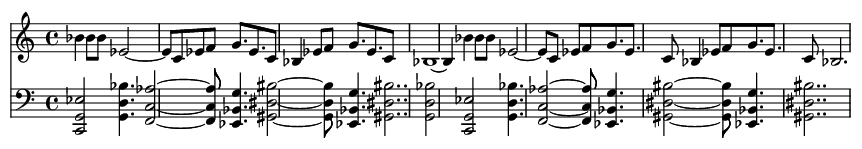

In [36]:
test_translation("I'm Coming Out")